In [1]:
%matplotlib inline

In [2]:
import numpy as np
import scipy.io
import os
import glob
import re
import pandas as pd
import h5py

import skimage.io

import matplotlib.pyplot as plt

## Load and Convert the MITOS 2014 Mitosis Classification dataset

Routines for loading and converting the datasets for the [MITOS 2014](https://mitos-atypia-14.grand-challenge.org/home/) challenge.
Please download the dataset directly from [the challenge homepage](https://mitos-atypia-14.grand-challenge.org/donwload/).

In [3]:
def read_annotations(root, template):
    ''' Read annotations and return them as a single pandas dataframe
    '''
    regex = re.compile('.*\/([a-z]*)\/.*\/.*\/([A-Z])([0-9]{2})_([0-9]{2})([A-Z])([a-z])_(.*mitosis)\.csv')
    
    columns = ['dataset','scanner','slide','frame','subframe','patch','class','xloc','yloc','confidence']

    df_annotations= pd.DataFrame(columns=columns)
    for file in glob.glob(os.path.join(root,template)):
        header = regex.search(file).groups()
        if os.path.getsize(file) == 0: continue
        df = pd.read_csv(file, header=None)
        for i in df.index:
            df_annotations = df_annotations.append({c:d for c,d in zip(columns, header+tuple(df.loc[i]))}, ignore_index=True)
    return df_annotations

def extract_images(root, annotations, pad=75):
    ''' Given an annotation file, read the images
    '''
    
    nb_examples = len(annotations)
    X = np.zeros((nb_examples,pad*2,pad*2,3)).astype('uint8')

    template_tiff = 'amira/{dataset}/{scanner}{slide}/frames/x40/A{slide}_{frame}{subframe}{patch}.tiff'

    for i in df_annotations.index:
        data = dict(df_annotations.loc[i])
        fname = template_tiff.format(**data)
        full_path = os.path.join(root, fname)

        im = skimage.io.imread(full_path)
        xloc, yloc = int(data['xloc']), int(data['yloc'])

        yloc_ = np.clip(yloc, pad, im.shape[0]-pad)
        xloc_ = np.clip(xloc, pad, im.shape[1]-pad)

        im = im[yloc_-pad:yloc_+pad,xloc_-pad:xloc_+pad]
        
        X[i,...] = im

    return X

Adapt the path to the dataset here.
The template should be adapted to match the following naming conventions:

```
{root}/aperio/train/A03/mitosis/A03_00Aa_mitosis.csv
```

for the Aperio Scanner and 

```
{root}/hamamatsu/train/A03/mitosis/A03_00Aa_mitosis.csv
```

for the Hamamatsu Scanner.
Please keep the file structure used in the original dataset files or adapt the template string below appropriately.

In [4]:
root     = '/home/students/sschneider/tmp/datasets/MITOS2014/'
template = 'amira/{dataset}/{scanner}{slide}/mitosis/A{slide}_{frame}{subframe}{patch}_{class}.csv'

In [5]:
columns  = ['dataset','scanner','slide','frame','subframe','patch','class','xloc','yloc','confidence']
search_template = template.format(**{c:'*' for c in columns})

df_annotations = read_annotations(root, search_template)

Show the annotations

In [195]:
print("Found {} annotations".format(len(df_annotations)))

df_annotations.loc[0:10]

Found 3633 annotations


,dataset,scanner,slide,frame,subframe,patch,class,xloc,yloc,confidence
0,train,A,04,00,A,b,mitosis,562.0,108.0,1.00
1,train,A,04,00,A,b,mitosis,430.0,467.0,1.00
2,train,A,04,00,A,b,mitosis,594.0,1026.0,1.00
3,train,A,04,00,A,c,mitosis,950.0,1258.0,1.00
4,train,A,04,00,A,c,mitosis,1222.0,1360.0,1.00
5,train,A,04,00,A,d,mitosis,163.0,1297.0,0.80
6,train,A,04,00,B,a,not_mitosis,1350.0,1084.0,0.20
7,train,A,04,00,B,b,mitosis,266.0,168.0,1.00
8,train,A,04,00,B,b,mitosis,971.0,616.0,0.65
9,train,A,04,00,B,b,mitosis,838.0,535.0,0.65


Load images and extract the label and domain (= slide) information from the annotation dataframe.

In [6]:
X      = extract_images(root,df_annotations,pad=75)
y      = (df_annotations['class'] == 'mitosis').as_matrix() * 1
domain = (df_annotations['slide']).as_matrix().astype("int")

Display some images. Note the due to the loading procedure above, the mitosis is not guaranteed to be centered in the patch.

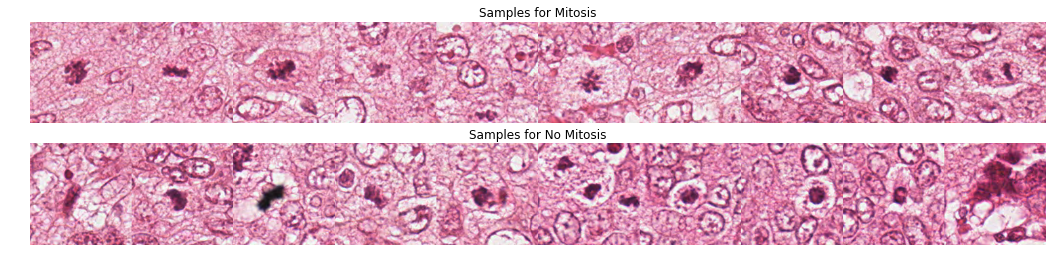

In [12]:
fig, axes = plt.subplots(2,1,figsize=(20,4))
axes[0].imshow(np.concatenate(X[y == 1][0:10], axis=1))
axes[0].set_title('Samples for Mitosis')
axes[1].imshow(np.concatenate(X[y == 0][0:10], axis=1))
axes[1].set_title('Samples for No Mitosis')
for ax in axes: ax.set_axis_off()

Optionally: Save the dataset

In [ ]:
#import h5py

#with h5py.File('mitos-p150-preliminary.hdf5') as ds:
#    ds['X'] = X             # images, shape (3633, 150, 150, 3)
#    ds['y'] = y             # label in 0, 1
#    ds['domain'] = domain   # slide no in 3,  4,  5,  7, 10, 11, 12, 14, 15, 17, 18